# CIC-IDS2018 anomaly detection using scikit-learn

目前打算做兩個方向
1. 用常用於anomaly detection的方法，例如Isolation Forest, One-class SVM, Local Outlier Factor, Robust Covariance, Elliptic Envelope等等，來做anomaly detection
2. 用常用於classification的方法，例如, XGBoost, KNN, Logistic Regression, catboost等等，結合起來做ensemble

import modules

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score
import seaborn as sns
from catboost import CatBoostClassifier, cv, Pool


## Load data

因為記憶體的限制分成三個部份，分別是良好的與除了`02-20-2018.csv`的異常資料，以及`02-20-2018.csv`的異常資料。

In [2]:
# def not_benign_load_data_and_concate():
#     csv_list = [file for file in os.listdir("./") if file.endswith('.csv') and file != 'all_not_benign_data.csv' and file != 'all_benign_data_sampled.csv' and file != 'all_not_benign_data_preprocessed.csv']
#     df_list = []
#     for i in csv_list:
#         df = pd.read_csv(i, low_memory=False)
#         if i == "02-20-2018.csv":
#                 df.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1,inplace=True)
#         df = df[df['Label'] != 'Benign']
#         df_list.append(df)
#     df = pd.concat(df_list, ignore_index=True)
#     df.to_csv('all_not_benign_data.csv', index=False)
#     print(df.info())
#     print(df['Label'].value_counts())

In [3]:
# not_benign_load_data_and_concate()

In [4]:
# def benign_load_data_and_concate():
#     csv_list = [file for file in os.listdir("./") if file.endswith('.csv') and file != 'all_not_benign_data.csv' and file != 'all_benign_data_sampled.csv' and file != 'all_not_benign_data_preprocessed.csv']
#     df_list = []
#     count = 0
#     for i in csv_list:
#         df = pd.read_csv(i, low_memory=False)
#         if i == "02-20-2018.csv":
#                 df.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1,inplace=True)
#         df = df[df['Label'] == 'Benign']
#         df = df.sample(frac=0.3)
#         df_list.append(df)
#         for j in df_list:
#             count += j.shape[0]
#             if count > 2748293:
#                 break
#     df = pd.concat(df_list, ignore_index=True)
#     df.to_csv('all_benign_data_sampled.csv', index=False)
#     print(df.info())
#     print(df['Label'].value_counts())

In [5]:
# benign_load_data_and_concate()

In [6]:
# df_benign = pd.read_csv('all_benign_data_sampled.csv', low_memory=False)
# df_not_benign = pd.read_csv('all_not_benign_data.csv', low_memory=False)

In [7]:
# df_merged = pd.concat([df_benign, df_not_benign], ignore_index=True)
# df_merged.to_csv('all_data_merged.csv', index=False)

## Data preprocessing

In [8]:
# df_merged = pd.read_csv('all_data_merged.csv', low_memory=False)

In [9]:
# def fixDataType(df):
#     df = df[df['Dst Port'] != 'Dst Port']
#     for i in df.columns:
#         if i == 'Label' or i == 'Timestamp':
#             continue
#         try:
#             df[i] = pd.to_numeric(df[i], downcast='integer')
#         except ValueError:
#             df[i] = pd.to_numeric(df[i], downcast='float')
    
#     return df

In [10]:
# Note: This preprocessing function is two classes
# def preprocess(df):
#     # fix data type
#     df = fixDataType(df)
    
#     # drop Label column if "Label" is in the column
#     mask = df["Label"] != "Label"
#     df = df.drop(df[~mask].index)
#     df.drop(df.loc[df['Label']=='Label'].index, inplace=True)
    
#     # drop timestamp
#     df = df.drop(columns=["Timestamp"], axis=1)
    
#     # replace infinity values with nan
#     df = df.replace(["Infinity", "infinity"], np.inf)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.dropna(inplace=True)
    
#     # drop constant columns
#     variances = df.var(numeric_only=True)
#     constant_columns = variances[variances == 0].index
#     df = df.drop(constant_columns, axis=1)
#     print("Constant columns: ", constant_columns)
    
#     stds = df.std(numeric_only=True)
#     constant_columns = stds[stds == 0].index
#     df = df.drop(constant_columns, axis=1)
#     print("std columns: ", constant_columns)
    
#     unique_counts = df.nunique()
#     constant_columns = unique_counts[unique_counts == 1].index
#     df = df.drop(constant_columns, axis=1)
#     print("Constant columns: ", constant_columns)
    
#     # drop duplicate columns
#     duplicates = set()
#     for i in range(0, len(df.columns)):
#         col1 = df.columns[i]
#         for j in range(i+1, len(df.columns)):
#             col2 = df.columns[j]
#             if(df[col1].equals(df[col2])):
#                 duplicates.add(col2)

#     print("duplicates", duplicates)
#     df.drop(duplicates, axis=1, inplace=True)
#     print(df.shape)
    

#     # convert label to binary
#     df['Label'] = df['Label'].apply(lambda x: 1 if x != 'Benign' else 0)
    
#     return df

In [11]:
# df_merged = preprocess(df_merged)
# df_merged.shape

In [12]:
# df_merged.info()

In [13]:
# df_merged['Label'].value_counts()

In [14]:
# # 將多數類別的樣本數減少到和少數類別的樣本數相等
# df_majority = df_merged[df_merged['Label'] == 0]
# df_minority = df_merged[df_merged['Label'] == 1]
# df_majority_downsampled = resample(df_majority, 
#                                    replace=False,    # 不放回抽樣
#                                    n_samples=len(df_minority),    # 抽樣數量等於少數類別的樣本數
#                                    random_state=42)  # 設定隨機種子，以便重現結果

# # 將少數類別和下採樣後的多數類別合併
# df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# # 打亂資料集
# df_downsampled = df_downsampled.sample(frac=1, random_state=42)

In [15]:
# df_downsampled['Label'].value_counts()

In [16]:
# df_downsampled.to_csv('all_data_merged_preprocessed.csv', index=False)

In [17]:
# df_merged = pd.read_csv('all_data_merged_preprocessed.csv', low_memory=False)

In [18]:
# plt.figure(figsize=(70, 70))
# corr = df_merged.corr(numeric_only=True)
# sns.heatmap(corr, annot=True, cmap='RdBu') # annot=True
# plt.show()

In [19]:
# correlated_col = set()
# corr = df_merged.corr(numeric_only=True)
# is_correlated = [True] * len(corr.columns)
# threshold = 0.70
# for i in range (len(corr.columns)):
#     if(is_correlated[i]):
#         for j in range(i):
#           if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
#             colname = corr.columns[j]
#             is_correlated[j]=False
#             correlated_col.add(colname)


# print(correlated_col)
# print(len(correlated_col))

In [20]:
# df_merged.drop(correlated_col, axis=1, inplace=True)
# print(df_merged.shape)

In [21]:
# # pearson correlation heatmap
# plt.figure(figsize=(70, 70))
# corr = df_merged.corr(numeric_only=True)
# sns.heatmap(corr, annot=True, cmap='RdBu') # annot=True
# plt.show()

In [22]:
# df_merged.to_csv('all_data_merged_completed.csv', index=False)

In [23]:
df_merged = pd.read_csv("all_data_merged_selected.csv")

In [24]:
df_merged["Dst Port"] = df_merged["Dst Port"].astype("category")

In [25]:
X = df_merged.drop(columns="Label", axis=1)
y = df_merged["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True, stratify=y)

In [26]:
# create a CatBoostClassifier object
clf_selected = CatBoostClassifier(eval_metric='AUC', random_seed=42, logging_level='Silent', iterations=500, learning_rate=0.5, depth=5, l2_leaf_reg=3)

# fit the classifier to the training data
clf_selected.fit(X_train, y_train, cat_features=["Dst Port"],plot=True, verbose=False, eval_set=(X_test, y_test), early_stopping_rounds=10, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy score:  0.9750353575894588
Confusion matrix: 
 [[1093125    5649]
 [  49212 1049562]]
Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98   1098774
           1       0.99      0.96      0.97   1098774

    accuracy                           0.98   2197548
   macro avg       0.98      0.98      0.98   2197548
weighted avg       0.98      0.98      0.98   2197548

Precision score:  0.9946465683166684
Recall score:  0.9552118998083319
F1 score:  0.974530463304062
ROC - AUC score:  0.9883729011706205


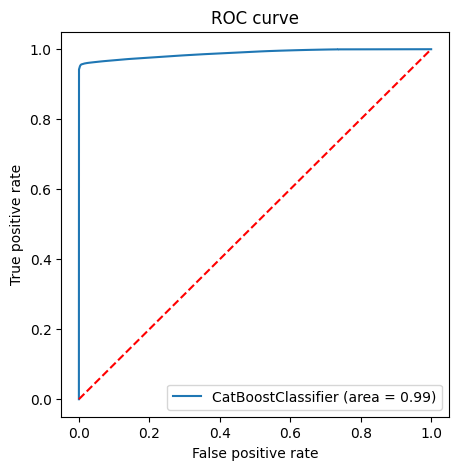

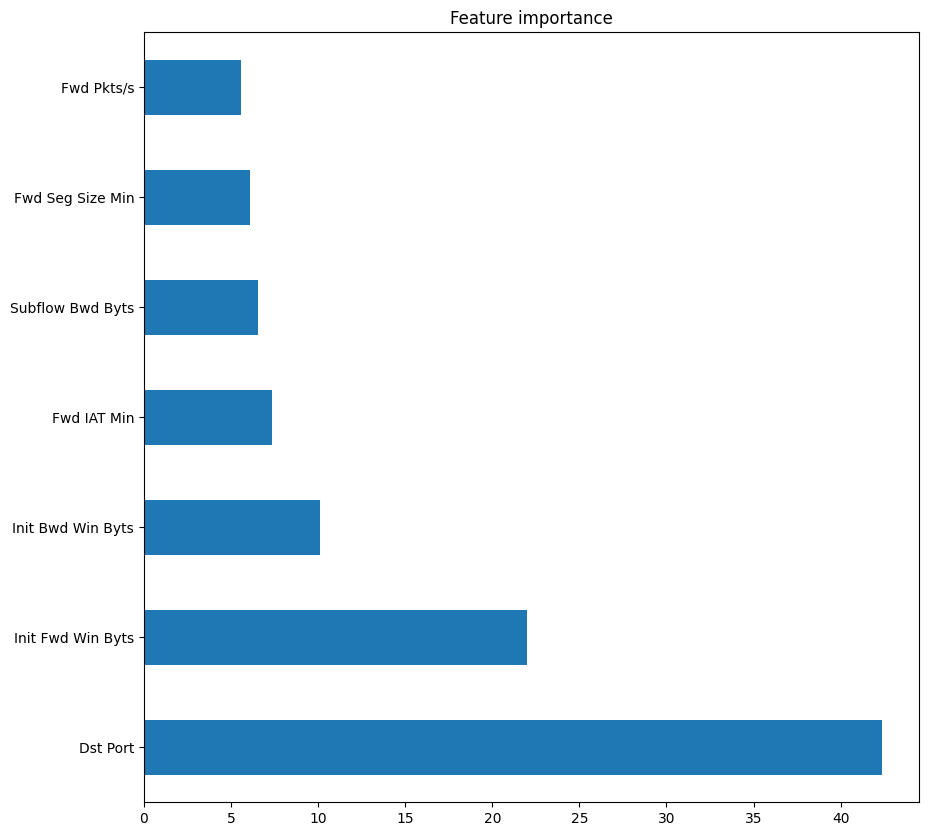

In [28]:
# plot metrics during training

# make the prediction using the resulting model
y_pred = clf_selected.predict(X_test)
y_pred_proba = clf_selected.predict_proba(X_test)[:, 1]

# print the accuracy score
print("Accuracy score: ", accuracy_score(y_test, y_pred))

# print the confusion matrix
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))

# print the classification report
print("Classification report: \n", classification_report(y_test, y_pred))

# print the precision score
print("Precision score: ", precision_score(y_test, y_pred))

# print the recall score
print("Recall score: ", recall_score(y_test, y_pred))

# print the F1 score
print("F1 score: ", f1_score(y_test, y_pred))

# print the ROC - AUC score
print("ROC - AUC score: ", roc_auc_score(y_test, y_pred_proba))

# plot AUC - ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='CatBoostClassifier (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

# plot feature importance
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(clf_selected.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature importance")
plt.show()


In [29]:
clf_selected.save_model("catboost_selected_model", format="cbm")